In [1]:
import numpy as np 
import pandas as pd 
import math
import random
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

**1. Load  data**

In [2]:
gender_submission = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/gender_submission.csv')
test = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/test.csv').set_index('PassengerId')
train = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/train.csv').set_index('PassengerId')

**2. Feature Exploration, Engineering and Cleaning**

*We create an index and remove the spaces in the data frame that we need to restore the age data of the remaining passengers. Add some new attributes such as the name length, whether the passenger had his own cabin and the deck number on which this cabin was*

In [3]:
df = pd.concat([train, test], axis=0, sort=False) 

In [4]:
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()

In [6]:
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female')) # !
df['LastName'] = df.Name.str.split(',').str[0]
family = df.groupby(df.LastName).Survived

df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0) # !

# Title !
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

# Embarked, Fare !
df['Embarked'] = df['Embarked'].fillna('S')
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)

# Cabin, Deck, famous_cabin !
df['famous_cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

# Family_Size !
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

# Name_length !
df['Name_length'] = df['Name'].apply(len)

df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [7]:
Y = df.Survived.loc[train.index].astype(int)
X_train, X_test = df.loc[train.index], df.loc[test.index]

In [8]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

Survived                 0
Pclass                   0
Name                     0
Sex                      0
Age                    177
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                  687
Embarked                 0
Title                    0
IsWomanOrBoy             0
LastName                 0
WomanOrBoyCount          0
FamilySurvivedCount      0
WomanOrBoySurvived       0
Alone                    0
famous_cabin             0
Deck                     0
Family_Size              0
Name_length              0
dtype: int64
Survived               418
Pclass                   0
Name                     0
Sex                      0
Age                     86
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                  327
Embarked                 0
Title                    0
IsWomanOrBoy             0
LastName                 0
WomanOrBoyCount

In [184]:
'''plt.figure(figsize=[12,10])

plt.subplot(331)
sns.distplot(X_train['Pclass'], color="k")

plt.subplot (332)                         
sns.barplot('Sex', 'Survived', data=X_train)

plt.subplot (333)
sns.distplot(X_dropna['Age']) 

plt.subplot (334)
#sns.distplot(X['SibSp'])
sns.barplot('SibSp', 'Survived', data=X_train)

plt.subplot (335)
#sns.distplot(X['Parch'])
#px.histogram(X, x="Parch").show()
sns.barplot('Parch', 'Survived', data=X_train)

plt.subplot (336)
sns.distplot(X_train['Fare'])
#train['Fare'].hist()

plt.subplot (337)
sns.barplot('Embarked', 'Survived', data=X_train)'''

'plt.figure(figsize=[12,10])\n\nplt.subplot(331)\nsns.distplot(X_train[\'Pclass\'], color="k")\n\nplt.subplot (332)                         \nsns.barplot(\'Sex\', \'Survived\', data=X_train)\n\nplt.subplot (333)\nsns.distplot(X_dropna[\'Age\']) \n\nplt.subplot (334)\n#sns.distplot(X[\'SibSp\'])\nsns.barplot(\'SibSp\', \'Survived\', data=X_train)\n\nplt.subplot (335)\n#sns.distplot(X[\'Parch\'])\n#px.histogram(X, x="Parch").show()\nsns.barplot(\'Parch\', \'Survived\', data=X_train)\n\nplt.subplot (336)\nsns.distplot(X_train[\'Fare\'])\n#train[\'Fare\'].hist()\n\nplt.subplot (337)\nsns.barplot(\'Embarked\', \'Survived\', data=X_train)'

In [9]:
cols_to_drop_train = ['Name','Ticket','Cabin']   
cols_to_drop_test = ['Name','Ticket','Cabin', 'Survived']
X_train = X_train.drop(cols_to_drop_train, axis=1)
X_test = X_test.drop(cols_to_drop_test, axis=1)

In [10]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = X_train.columns.values.tolist()
for col in features:
    if X_train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

In [11]:
# Encoding categorical features
for col in categorical_columns:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))   

In [12]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [13]:
X_dropna_categor = X_train.dropna().astype(int)
Xtest_dropna_categor = X_test.dropna().astype(int)

**3. Recover Missed Values**

*Initially, we divide the sample into 4 subsamples of surviving men and women and non-survivors. Next, we find the mean and standard deviations for each subsample, we need them to find the confidence interval for the location of the mean from the population. The derf function finds a confidence interval.*

In [14]:
# Surviving girls:
Sex_female_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 1)]
# Dead girls:
Sex_female_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 0)]
# Surviving guys:
X_Sex_male_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 1)] 
# Dead guys:
X_Sex_male_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 0)]

X_test_male = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 1]
X_test_female = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 0]

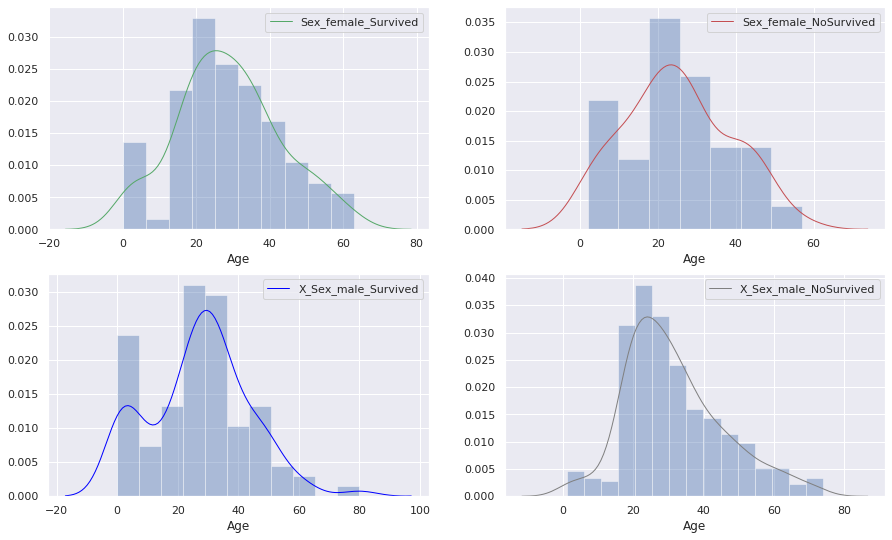

In [15]:
# age distribution of survivors and non-survivors:
sns.set(rc={'figure.figsize': (15, 9)})
plt.subplot (221)
sns.distplot(Sex_female_Survived['Age'] , kde_kws = {'color': 'g', 'lw':1, 'label': 'Sex_female_Survived' })
plt.subplot (222)
sns.distplot(Sex_female_NoSurvived['Age'] , kde_kws = {'color': 'r', 'lw':1, 'label': 'Sex_female_NoSurvived' })
plt.subplot (223)
sns.distplot(X_Sex_male_Survived['Age'] , kde_kws = {'color': 'blue', 'lw':1, 'label': 'X_Sex_male_Survived' })
plt.subplot (224)
sns.distplot(X_Sex_male_NoSurvived['Age'] , kde_kws = {'color': 'gray', 'lw':1, 'label': 'X_Sex_male_NoSurvived' })

In [16]:
female_Survived_mean, female_NoSurvived_mean = Sex_female_Survived['Age'].mean(), Sex_female_NoSurvived['Age'].mean()
male_Survived_mean, male_NoSurvived_mean = X_Sex_male_Survived['Age'].mean(), X_Sex_male_NoSurvived['Age'].mean()

female_Survived_std, female_NoSurvived_std = Sex_female_Survived['Age'].std(), Sex_female_NoSurvived['Age'].std()
male_Survived_std, male_NoSurvived_std = X_Sex_male_Survived['Age'].std(), X_Sex_male_NoSurvived['Age'].std()

female_std, female_mean = X_test_female['Age'].std(), X_test_female['Age'].mean()
male_std, male_mean = X_test_male['Age'].std(), X_test_male['Age'].mean()

In [17]:
# Confidence interval calculation function: 
def derf(sample, mean, std):
    age_shape = sample['Age'].shape[0] # sample size
    standard_error_ofthe_mean = std / math.sqrt(age_shape)
    random_mean = random.uniform(mean-(1.96*standard_error_ofthe_mean), mean+(1.96*standard_error_ofthe_mean))
    return round(random_mean, 2)    

In [18]:
X_train['Survived'] = X_train['Survived'].astype(int)

In [19]:
X_train.head(2) #IsWomanOrBoy 	LastName 	WomanOrBoyCount 	FamilySurvivedCount 	WomanOrBoySurvived

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,famous_cabin,Deck,Family_Size,Name_length
0,1,0,3,1,22.0,1,0,7.2500,2,10,0,100,0.0,0.0,0.0,1,0,7,2,23
1,2,1,1,0,38.0,1,0,71.2833,0,11,1,182,1.0,0.0,0.0,0,1,2,2,51


In [20]:
for i in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[i, 'Age'] = derf(Sex_female_Survived, female_Survived_mean, female_Survived_std)

for h in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[h, 'Age'] = derf(Sex_female_NoSurvived, female_NoSurvived_mean, female_NoSurvived_std)
    
for l in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[l, 'Age'] = derf(X_Sex_male_Survived, male_Survived_mean, male_Survived_std)
    
for b in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[b, 'Age'] = derf(X_Sex_male_NoSurvived, male_NoSurvived_mean, male_NoSurvived_std)
    
for p in X_test.loc[(X_test['Sex']==1) & (X_test['Age'].isnull())].index:
    X_test.at[p, 'Age'] = derf(X_test_male, male_mean, male_std)

for y in X_test.loc[(X_test['Sex']==0) & (X_test['Age'].isnull())].index:
    X_test.at[y, 'Age'] = derf(X_test_female, female_mean, female_std)


In [21]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Title                  0
IsWomanOrBoy           0
LastName               0
WomanOrBoyCount        0
FamilySurvivedCount    0
WomanOrBoySurvived     0
Alone                  0
famous_cabin           0
Deck                   0
Family_Size            0
Name_length            0
dtype: int64
PassengerId            0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Title                  0
IsWomanOrBoy           0
LastName               0
WomanOrBoyCount        0
FamilySurvivedCount    0
WomanOrBoySurvived     0
Alone                  0
famous_cabin           0
Deck                   0
Family_Size            0
Name_length            0
dtype: int64

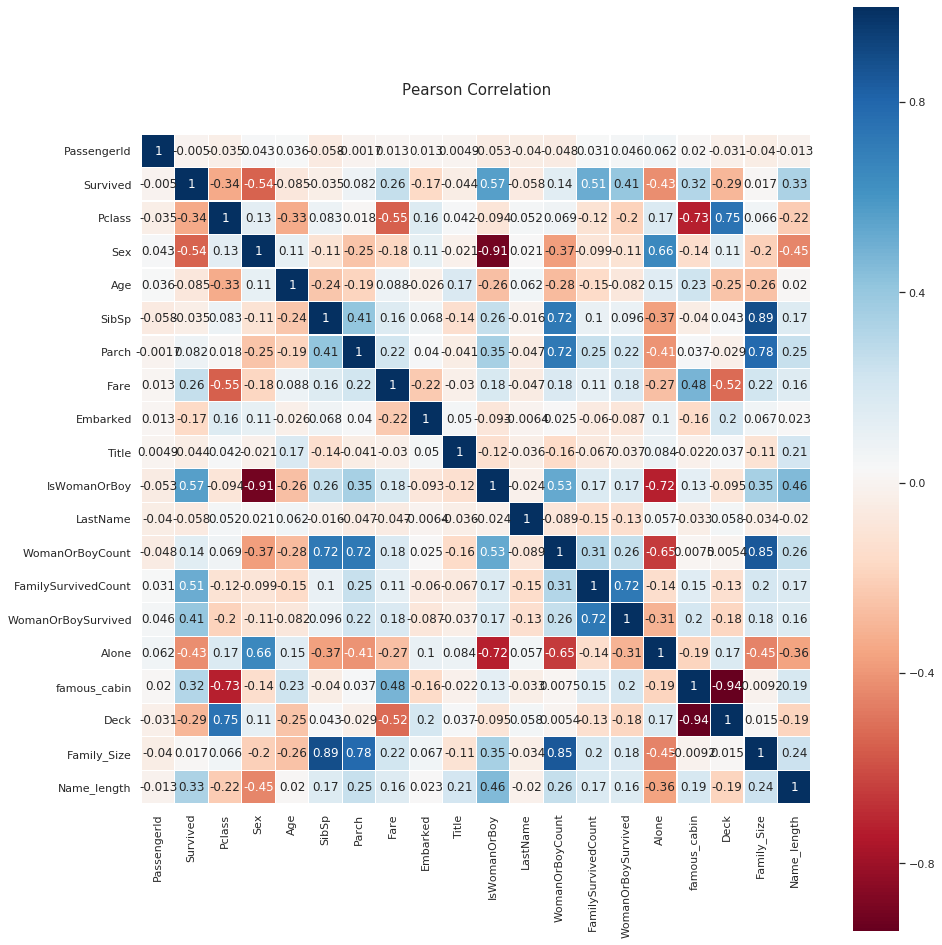

In [22]:
cor_map = plt.cm.RdBu
plt.figure(figsize=(15,17))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=cor_map, linecolor='white', annot=True)  

In [23]:
X_train = X_train.drop(['Survived'], axis = 1)

**4. Define classifiers**

In [24]:
rf = RandomForestClassifier()

In [25]:
random_grid = {'criterion': ['gini', 'entropy'],
               'bootstrap': [True, False],
               'max_depth': [3, 5, 7, 9, 11, 13, 16, 19, 20],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [5, 10, 15, 20, 25],
               'min_samples_split': [40, 50, 60, 62, 64, 66, 68],
               'n_estimators': [300, 600, 900, 1200, 1500, 1800]}

In [26]:
rf_search_one = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100)

In [27]:
print(X_train.shape)
print(Y.shape)
print(X_test.shape)

(891, 19)
(891,)
(418, 19)


In [28]:
rf_search_one.fit(X_train, Y)
#rf_search_one.fit(X_train_rf_1, y_train_rf_1)
best_rf_s1 = rf_search_one.best_estimator_
#best_rf_s1.fit(X_train_rf_1, y_train_rf_1)
best_rf_s1.fit(X_train, Y)
y_predicted_prob_1 = best_rf_s1.predict(X_test) 
print(best_rf_s1.classes_)
y_predicted_prob_1 = list(y_predicted_prob_1)
print('finish')

/home/slay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[0 1]
finish


In [29]:
print(rf_search_one.best_params_)

{'n_estimators': 1500, 'min_samples_split': 50, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': False}


In [30]:
finall_F = pd.DataFrame.from_dict({'PassengerId': list(X_test.PassengerId), 'Survived': y_predicted_prob_1})

In [31]:
finall_F.head(6)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0


In [32]:
finall_F.to_csv("Submission_test8.csv", index=False)